_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student name: Moritz Kniebel, Vanessa Tsingunidis

# Coding Lab 4

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv('../data/nda_ex_4_ogb_calcium.csv', header=0)  
ogb_spikes = pd.read_csv('../data/nda_ex_4_ogb_spikes.csv', header=0)  

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv('../data/nda_ex_4_gcamp2_calcium.csv', header=0)  
gcamp_spikes = pd.read_csv('../data/nda_ex_4_gcamp2_spikes.csv', header=0)  


In [3]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [4]:
ogb_spikes.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

(71986, 11)


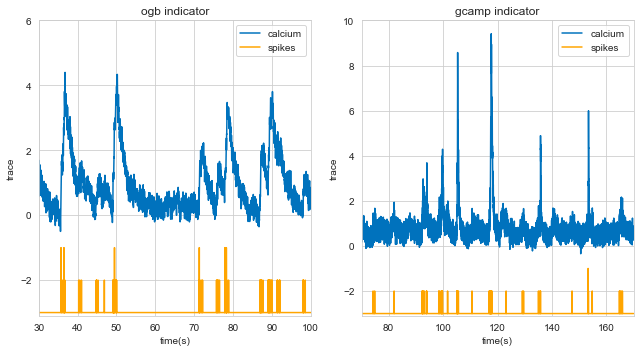

In [5]:
# Use cell 5 as an example
print(ogb_calcium.shape)

fig, ax = plt.subplots(1,2, figsize=(9,5))

fs = 100  # as given sampling frequency of 100Hz
t = np.array(range(ogb_calcium.shape[0]))/fs
t_start = 30
sample_start = int(t_start*fs)
t_end = 170
sample_end = int(t_end*fs)
ax[0].plot(t[sample_start:sample_end],ogb_calcium.iloc[sample_start:sample_end,4], color = '#0072BD', label = 'calcium')
ax[0].plot(t[sample_start:sample_end],ogb_spikes.iloc[sample_start:sample_end,4]-3, color = '#FFA500', label = 'spikes')
ax[0].set_title('ogb indicator')
ax[0].set_xlim(30,100)
ax[0].set_xlabel('time(s)')
ax[0].set_ylim(-3.1,6)
ax[0].set_ylabel('trace')
ax[0].legend()

ax[1].plot(t[sample_start:sample_end],gcamp_calcium.iloc[sample_start:sample_end,5], color = '#0072BD', label = 'calcium')
ax[1].plot(t[sample_start:sample_end],gcamp_spikes.iloc[sample_start:sample_end,5]-3, color= '#FFA500', label = 'spikes')
ax[1].set_title('gcamp indicator')
ax[1].set_xlim(70,170)
ax[1].set_xlabel('time(s)')
ax[1].set_ylim(-3.1,10)
ax[1].set_ylabel('trace')
ax[1].legend()
fig.tight_layout()
plt.show()
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------

# --------------------------
# Plot raw spike data (1 pt)
# --------------------------

plt.show()

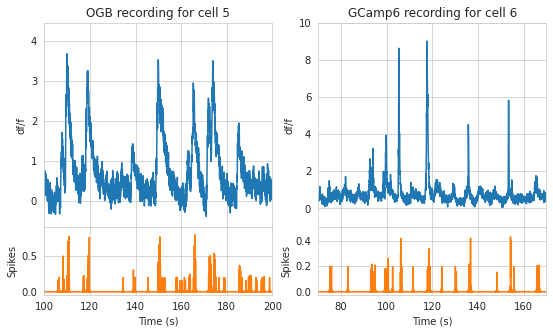

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons.

*Grading: 3 pts*


In [6]:
def deconv_ca(ca, tau, dt):
    '''Compute the BIC for a fitted Mixture of Gaussian model
    
    Parameters
    ----------
    
    ca: np.array, (n_points,)
        Calcium trace
    
    tau: float
        decay constant of conv kernel
    
    dt: float
        sampling interval.
    
    Return
    ------
    
    sp_hat: np.array    
    '''
    t = np.arange(0,100)*dt # sampling frequency to get time vector

    kernel = np.exp(-t/tau)  # exponential kernel function depending on tau 
    
    sp_hat, _ = signal.deconvolve(ca, kernel)
    sp_hat[sp_hat<0] = 0 #heavyside function, no negative rates

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    return sp_hat

0.04


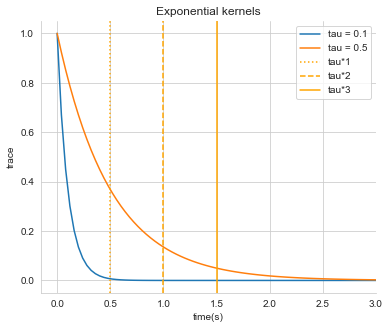

In [7]:


plt.figure(figsize=(6,5))
fs = 25
dt = 1/fs
print(dt)
for tau in [0.1, 0.5]:
    t = np.arange(0,100)*dt # time vector
    kernel = np.exp(-t/tau)
    plt.plot(t, kernel, label = 'tau = '+str(tau))
plt.axvline(tau,color = '#FFA500', label='tau*1', linestyle='dotted')
plt.axvline(tau*2,color = '#FFA500', label='tau*2', linestyle='--')
plt.axvline(tau*3,color = '#FFA500', label='tau*3')
plt.xlim(-0.15,3)
plt.xlabel('time(s)')
plt.ylabel('trace')
plt.title('Exponential kernels')
plt.legend()


# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

sns.despine()

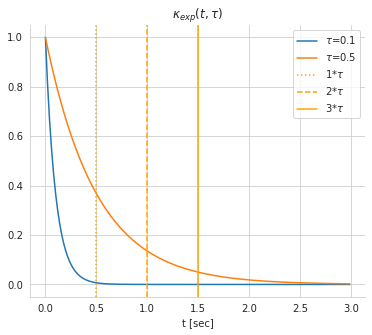

In [8]:
# Apply function to OGB cell
idx = 4
ca = signal.decimate(ogb_calcium.iloc[:,idx], 4) # for GCamP use camp_calcium
sp = signal.decimate(ogb_spikes.iloc[:,idx], 4) # for GCamP use gcamp_spikes
sp[sp<0] = 0 # remove decimation artefacts

tau = .5 # in sec
dt = 1/25 # in sec only for OGB

sp_hat = deconv_ca(ca, dt, tau) # for GCamP exchange dt with sp


(17898,)


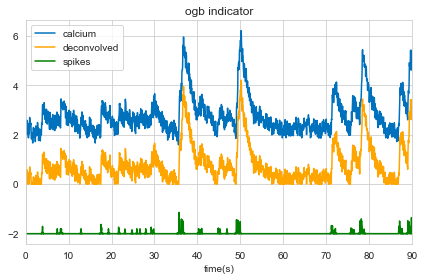

In [9]:


#fig = plt.figure(figsize=(6,4))

fs = 25  # sampling frequency of 100Hz
t = np.array(range(ogb_calcium.shape[0]))/fs
t_start = 0
sample_start = int(t_start*fs)
t_end = 90
sample_end = int(t_end*fs)

# fill in plot here
t = np.arange(sample_start,sample_end)*dt
print(sp_hat.shape)
fig = plt.figure(figsize = (6,4))
plt.plot(t,ca[sample_start:sample_end]+2, color = '#0072BD', label = 'calcium')
plt.plot(t,sp_hat[sample_start:sample_end], color = '#FFA500', label = 'deconvolved')
plt.plot(t,sp[sample_start:sample_end]-2, color = 'green', label = 'spikes')
plt.title('ogb indicator')
plt.xlim(0,90)
plt.xlabel('time(s)')
plt.legend()
plt.tight_layout()
plt.show()
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

plt.show()

(5895,)


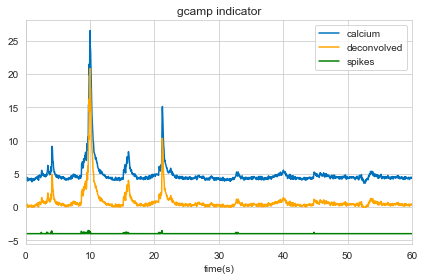

In [10]:
# Apply function to GCamP cell
idx = 5
ca = signal.decimate(gcamp_calcium.iloc[:,idx], 4) # for GCamP use camp_calcium
sp = signal.decimate(gcamp_spikes.iloc[:,idx], 4) # for GCamP use gcamp_spikes
sp[sp<0] = 0 # remove decimation artefacts

tau = .1 # in sec
dt = 1/25 # in sec only for OGB

sp_hat = deconv_ca(ca, dt, tau)


fs = 25  # sampling frequency of 100Hz
#t = np.array(range(gcamp_calcium.shape[0]))/fs
t_start = 0
sample_start = int(t_start*fs)
t_end = 60
sample_end = int(t_end*fs)

# fill in plot here
t = np.arange(sample_start,sample_end)*dt
print(sp_hat.shape)
fig = plt.figure(figsize = (6,4))
plt.plot(t,ca[sample_start:sample_end]+4, color = '#0072BD', label = 'calcium')
plt.plot(t,sp_hat[sample_start:sample_end], color = '#FFA500', label = 'deconvolved')
plt.plot(t,sp[sample_start:sample_end]-4, color = 'green', label = 'spikes')
plt.title('gcamp indicator')
plt.xlim(0,60)
plt.xlabel('time(s)')
plt.legend()
plt.tight_layout()
plt.show()
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

plt.show()

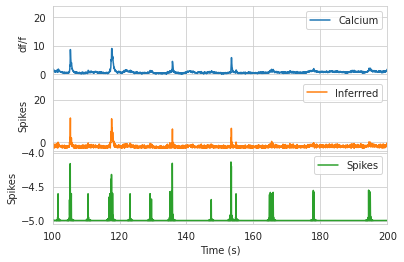

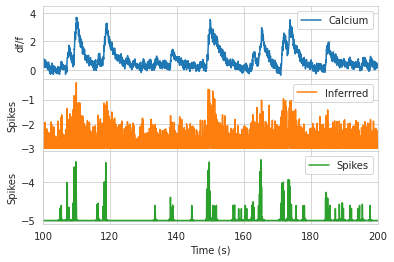

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [11]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------
from oopsi import *

idx = 4
spikes = signal.decimate(ogb_spikes.iloc[:,idx], 4)
calcium = signal.decimate(ogb_calcium.iloc[:,idx], 4)
spikes[spikes<0] = 0

n_best, C_best = fast(calcium, dt)

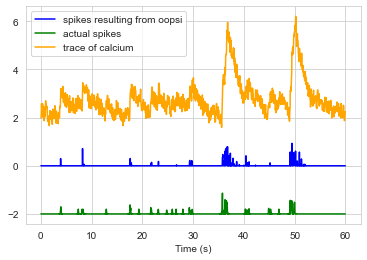

In [12]:
fig = plt.figure(figsize=(6,4))

# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------
plt.plot(t,n_best[sample_start:sample_end], color = 'blue', label = 'spikes resulting from oopsi')
plt.plot(t,spikes[sample_start:sample_end]-2, color = 'green', label = 'actual spikes')
plt.plot(t,calcium[sample_start:sample_end]+2, color = 'orange', label = 'trace of calcium')

plt.xlabel('Time (s)')
plt.legend()

plt.show()

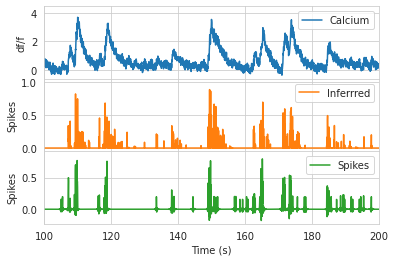

In [13]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------
idx = 5
calcium = signal.decimate(gcamp_calcium.iloc[:,idx], 4)
spikes = signal.decimate(gcamp_spikes.iloc[:,idx], 4)
spikes[spikes<0] = 0


# fill in algorithm here
n_best,_ = fast(calcium,dt)

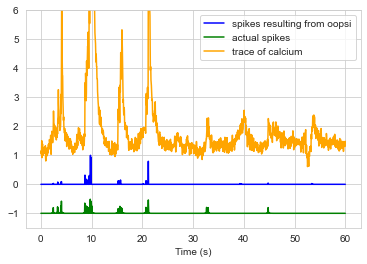

In [14]:
fig = plt.figure(figsize=(6,4))

# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------
plt.plot(t,n_best[sample_start:sample_end], color = 'blue', label = 'spikes resulting from oopsi')
plt.plot(t,spikes[sample_start:sample_end]-1, color = 'green', label = 'actual spikes')
plt.plot(t,calcium[sample_start:sample_end]+1, color = 'orange', label = 'trace of calcium')

plt.xlabel('Time (s)')
plt.ylim(-1.5,6)
plt.legend()

plt.show()

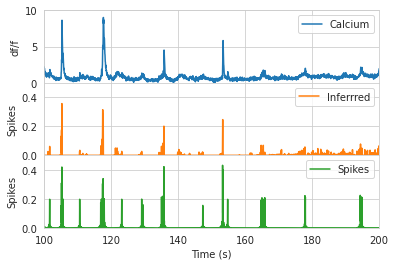

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


Evaluate on OGB data

In [15]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------
ogb_calcium[np.isnan(ogb_calcium)] = 0
ogb_spikes[np.isnan(ogb_spikes)] = 0
  
ogb_df = pd.DataFrame(columns=['Algorithm', 'Correlation', 'Indicator'])
dt = 1/25
tau = .5

num_cells = ogb_calcium.shape[1]
algorithm_names = []
for algo in [['deconv'],['oopsi']]:
    algorithm_names.append(np.tile(algo,num_cells))
ogb_df['Algorithm'] = np.concatenate(algorithm_names)
ogb_df['Indicator'] = np.tile('ogb',num_cells*2)
correlations = []

for i in range(num_cells):
    spikes = signal.decimate(ogb_spikes.iloc[:,i], 4)
    calcium = signal.decimate(ogb_calcium.iloc[:,i], 4)    
        
    spikes_oopsi,_ = fast(calcium,dt)    
    spikes_deconv = deconv_ca(calcium,dt,tau)
    sp_adj = spikes[:np.min([len(spikes_deconv),len(spikes)])]
    
    corr_deconv = np.corrcoef(spikes_deconv, sp_adj)[-1,0]
    sp_adj = spikes[:np.min([len(spikes),len(spikes_oopsi)])]
    
    corr_oopsi = np.corrcoef(spikes_oopsi, sp_adj)[-1,0]
    ogb_df['Correlation'].iloc[i]= corr_deconv
    ogb_df['Correlation'].iloc[i+num_cells]= corr_oopsi 

Create OGB dataframe

In [16]:
display(ogb_df)

,Algorithm,Correlation,Indicator
0,deconv,0.211652,ogb
1,deconv,0.0904436,ogb
2,deconv,0.140675,ogb
3,deconv,0.115235,ogb
4,deconv,0.198591,ogb
5,deconv,0.177386,ogb
6,deconv,0.206841,ogb
7,deconv,0.208244,ogb
8,deconv,0.0932277,ogb
9,deconv,0.274198,ogb


Evaluate on GCamp data

In [17]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------
gcamp_calcium[np.isnan(gcamp_calcium)] = 0
gcamp_spikes[np.isnan(gcamp_spikes)] = 0
  
gcamp_df = pd.DataFrame(columns=['Algorithm', 'Correlation', 'Indicator'])
dt = 1/25
tau = .1

num_cells = gcamp_calcium.shape[1]
algorithm_names = []
for algo in [['deconv'],['oopsi']]:
    algorithm_names.append(np.tile(algo,num_cells))
gcamp_df['Algorithm'] = np.concatenate(algorithm_names)
gcamp_df['Indicator'] = np.tile('gcamp',num_cells*2)
correlations = []

for i in range(num_cells):
    spikes = signal.decimate(gcamp_spikes.iloc[:,i], 4)
    calcium = signal.decimate(gcamp_calcium.iloc[:,i], 4)
    
    
    spikes_deconv = deconv_ca(calcium,dt,tau)
    spikes_oopsi,_ = fast(calcium,dt)

    sp_adj = spikes[:np.min([len(spikes_deconv),len(spikes)])]
    corr_deconv = np.corrcoef(spikes_deconv, sp_adj)[-1,0]

    sp_adj = spikes[:np.min([len(spikes),len(spikes_oopsi)])]
    corr_oopsi = np.corrcoef(spikes_oopsi, sp_adj)[-1,0]
    gcamp_df['Correlation'].iloc[i]= corr_deconv
    gcamp_df['Correlation'].iloc[i+num_cells]= corr_oopsi 


Create GCamp dataframe

In [18]:
display(gcamp_df)

,Algorithm,Correlation,Indicator
0,deconv,0.374734,gcamp
1,deconv,0.304547,gcamp
2,deconv,0.324936,gcamp
3,deconv,0.343062,gcamp
4,deconv,0.170646,gcamp
...,...,...,...
69,oopsi,0.621283,gcamp
70,oopsi,0.618206,gcamp
71,oopsi,0.621272,gcamp
72,oopsi,0.584769,gcamp


Combine both dataframes and plot

/Users/moreez/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


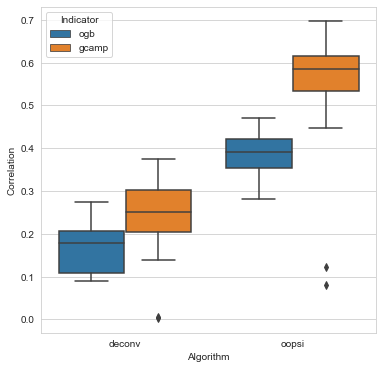

/Users/moreez/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


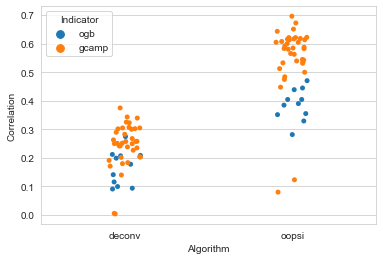

In [19]:
plt.figure(figsize=(6, 6))

# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# ---------------------------------------------------------------------------
joint_df = pd.concat([ogb_df,gcamp_df])

sns.boxplot(joint_df.iloc[:,0], joint_df.iloc[:,1], hue=joint_df.iloc[:,2])
plt.show()

sns.stripplot(joint_df.iloc[:,0], joint_df.iloc[:,1], hue=joint_df.iloc[:,2])
plt.show()

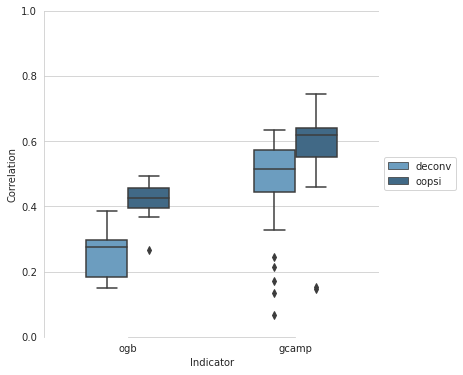